## Import Needed Libraries


In [1]:
import re
import io
import os
import sys
import requests
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from pathlib import Path
from datasets import load_dataset
from torch.utils.data import DataLoader, random_split

In [2]:
device = torch.device('cuda:1')

In [3]:
seed = 854
torch.manual_seed(seed)

## VQGAN as Image Encoder

In [4]:
from PIL import Image
from dall_e import map_pixels

In [5]:
from vqgan_jax.modeling_flax_vqgan import VQModel

# Load the pre-trained VQGAN model and its processor
checkpoint = "dalle-mini/vqgan_imagenet_f16_16384"
vqmodel = VQModel.from_pretrained(checkpoint)

CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content))

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = np.clip(x, -1., 1.)
  x = (x + 1.)/2.
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def preprocess(img, target_image_size=256,):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img.permute(0, 2, 3, 1).numpy()

In [7]:
image_vocab_len = vqmodel.config.n_embed
print("image_vocab_len:", image_vocab_len)

image_vocab_len: 16384


In [8]:
url='https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1'
size=256
image = download_image(url)
image = preprocess(image, size)

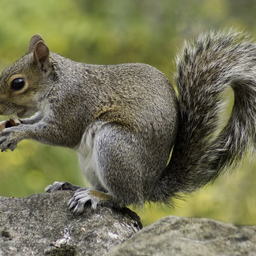

In [9]:
custom_to_pil(preprocess_vqgan(image[0]))

In [10]:
quant_states, indices = vqmodel.encode(image)
indices.shape

(1, 256)

In [11]:
rec = vqmodel.decode(quant_states)

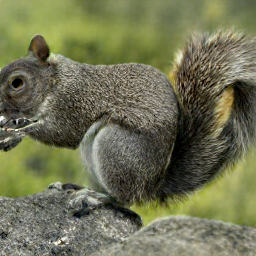

In [12]:
custom_to_pil(preprocess_vqgan(np.asarray(rec[0])))

## Text LLM

In [13]:
# from transformers import LlamaTokenizer, LlamaForCausalLM
# import transformers
# import torch

# llm = "meta-llama/Llama-2-7b-hf"
# model = LlamaForCausalLM.from_pretrained(llm)
# tokenizer = LlamaTokenizer.from_pretrained(llm)

In [14]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained GPT-2 model and tokenizer
llm = "gpt2"
model = GPT2LMHeadModel.from_pretrained(llm)
llm_tokenizer = GPT2Tokenizer.from_pretrained(llm)

In [15]:
embeddings = model.lm_head.weight
# embedding_matrix = model.transformer.wte.weight
llm_feature_dim = model.config.hidden_size
llm_vocab_len = model.config.vocab_size
model.to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [16]:
for param in model.parameters():
    param.requires_grad = False

In [17]:
print("gpt2 feature dim length:", llm_feature_dim)
print("gpt2 vocabulary length:", llm_vocab_len)
print("gpt2 embedding shape:", embeddings.shape)

gpt2 feature dim length: 768
gpt2 vocabulary length: 50257
gpt2 embedding shape: torch.Size([50257, 768])


## Mapper Network

map some modality to text token's feature dimension

In [18]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

In [19]:
class TokenMapper(nn.Module):
    def __init__(self, input_dim, output_dim, device="cpu"):
        super().__init__()
        self.mapper = nn.Linear(input_dim, output_dim)
        self.mapper.to(device)

    def forward(self, one_hot_token):
        return self.mapper(one_hot_token)

In [20]:
# Create the mapper
# mapper maps vocabulary_size of target modality to feature_dimension size of llm
# mapper = TokenMapper(midi_vocab_len, llm_feature_dim, device=device)
mapper = TokenMapper(image_vocab_len, llm_feature_dim, device=device)

In [21]:
mapper

TokenMapper(
  (mapper): Linear(in_features=16384, out_features=768, bias=True)
)

In [22]:
reverseMapper = TokenMapper(image_vocab_len, llm_feature_dim, device=device)

In [23]:
reverseMapper

TokenMapper(
  (mapper): Linear(in_features=16384, out_features=768, bias=True)
)

## Prompt Network

In [24]:
prompt_len = 0

In [25]:
class Prompt(nn.Module):
    def __init__(self, input_dim, output_dim, device="cpu"):
        super().__init__()
        self.model = nn.Linear(input_dim, output_dim, bias=False)
        self.model.to(device)

    def forward(self, one_hot_token):
        return self.model(one_hot_token)

In [26]:
if prompt_len!=0:
    prompt = Prompt(prompt_len, llm_feature_dim, device=device)
    prompt_inputs = F.one_hot(torch.arange(prompt_len), num_classes=prompt_len).float().to(device)

## Generate Ground Truth

In [27]:
def generate_next_token_predictions(token_sequences):
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(input_ids=token_sequences, output_hidden_states=True)
    
    return outputs.hidden_states[-1]

In [28]:
def generate_next_token_predictions_withfv(token_fv):
    
    # Get model predictions
    outputs = model(inputs_embeds=token_fv, output_hidden_states=True)
    
    return outputs.hidden_states[-1]

In [29]:
def translate(batch_feature_vectors, embeddings, temperature=1.0):
    batch_size, seq_len, embedding_dim = batch_feature_vectors.shape

    # Normalize the embedding matrix
    embedding_matrix_norm = F.normalize(embeddings, dim=1)

    batch_feature_vector_norm = F.normalize(batch_feature_vectors, dim=2)
    cosine_similarities = torch.matmul(batch_feature_vector_norm, embedding_matrix_norm.T)
    # cosine_similarities = torch.matmul(batch_feature_vectors, embeddings.T)
    sfmx = torch.softmax(cosine_similarities/temperature, dim=2)
    closest_tokens = torch.argmax(sfmx, dim=2)
    
    mm = torch.matmul(sfmx, embeddings)

    return mm, cosine_similarities, closest_tokens

In [30]:
# def translate(batch_feature_vectors, embeddings, temperature=1.0):
#     batch_size, seq_len, embedding_dim = batch_feature_vectors.shape

#     closest_tokens = torch.zeros((batch_size, seq_len), dtype=torch.float).to(device)
#     mm = torch.zeros((batch_size, seq_len, embeddings.size(1)), dtype=torch.float).to(device)
    
#     for i in range(batch_size):
#         # Normalize the feature vectors for the i-th sample in the batch
#         feature_vectors_norm = F.normalize(batch_feature_vectors[i], dim=1)

#         # Compute cosine similarity for the entire sequence at once
#         cosine_similarities = torch.matmul(feature_vectors_norm, embedding_matrix_norm.T)

#         # Find the token with the highest similarity for each feature vector
#         closest_tokens[i] = torch.argmax(cosine_similarities, dim=1)

#         mm[i] = torch.matmul(torch.softmax(cosine_similarities / temperature, dim=1), embeddings)


#     return mm, cosine_similarities, closest_tokens

## Get Image Dataset

In [31]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms, datasets

In [32]:
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize to a fixed size; adjust as needed
#     transforms.ToTensor(),          # Convert images to PyTorch tensors
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize (mean, std) for each color channel
# ])

In [33]:
image_size = 256

def resize_and_crop(img):
    # Resize while maintaining aspect ratio and center crop
    s = min(img.size)
    r = image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [image_size])
    return img

def modified_map_pixels(img):
    # Add a batch dimension, apply map_pixels, and then remove the batch dimension
    img = img.unsqueeze(0)
    img = map_pixels(img)
    return img.squeeze(0)

transform = transforms.Compose([
            transforms.Lambda(resize_and_crop),
            transforms.ToTensor(),
            transforms.Lambda(modified_map_pixels)
        ])

In [34]:
# Replace 'path/to/lsun' with the actual path to your LSUN dataset
dataset_path = '../data/lsun'

lsun_dataset = datasets.LSUN(root=dataset_path, classes=['classroom_train'], transform=transform)

In [35]:
batch_size = 5  # Adjust based on your memory availability and requirements
lsun_loader = DataLoader(lsun_dataset, batch_size=batch_size, shuffle=True)
print('dataset size:',len(lsun_loader))

dataset size: 33621


## Reinforce Loss

In [36]:
def Reinforce_Loss(logits, translated, loss, gamma=0.9, alpha=1, temperature=1):
    """
    Calculate the REINFORCE loss for sequence prediction.

    :param logits: Logits from the model, shape [batch_size, seq_len, vocab_size].
    :param targets: Ground truth sequence, shape [batch_size, seq_len].
    :param rewards: Reward for each step in the sequence, shape [batch_size, seq_len].
    :param gamma: Discount factor for future rewards.
    :return: The REINFORCE loss (to be maximized).
    """
    batch_size, seq_len, _ = logits.shape
    translated = translated.to(torch.int64)
    # shape = [batch_size, seq_len, llm_vocab_len]
    log_probs = F.log_softmax(logits/temperature, dim=-1)
    log_probs_targets = log_probs.gather(2, translated.unsqueeze(2)).squeeze(2)
    
    # Create a discount matrix
    discount_matrix = torch.zeros((seq_len, seq_len)).to(device)

    # Fill the matrix according to the given pattern
    for i in range(seq_len):
        for j in range(i, seq_len):
            discount_matrix[i, j] = gamma ** (j - i)

    normalize_factor = discount_matrix.sum(dim=1)
    
    # Calculate discounted rewards
    discounted_loss = loss.unsqueeze(1) * discount_matrix
    cumulative_loss = discounted_loss.sum(dim=-1) / normalize_factor / alpha
    
    # Calculate loss
    total_loss = torch.sum(log_probs_targets * cumulative_loss) / batch_size / seq_len

    return total_loss

## Train Model

In [37]:
# Hyper Parameters
learning_rate = 5e-4
epochs = 1
gamma = 0.1
temperature = 0.001
alpha = 1

In [38]:
experiment = "base_dual"
algo = "base"
exp_type = "image"
name = "vqgan"
experiment_name = f"{exp_type}/{algo}/{experiment}/{name}/{llm}/lr={learning_rate},gamma={gamma},temp={temperature},promptlen={prompt_len}"

In [39]:
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter instance (logs will be saved in 'runs' folder)
writer = SummaryWriter(log_dir = f'../runs/{experiment_name}')

In [40]:
criterion = nn.CrossEntropyLoss()
if prompt_len==0:
    optimizer = optim.Adam(list(mapper.parameters()) + list(reverseMapper.parameters()), lr=learning_rate)
else:
    optimizer = optim.Adam(list(mapper.parameters()) + list(prompt.parameters()), lr=learning_rate)
rl_criterion = nn.CrossEntropyLoss(reduction='none')
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [42]:
for epoch in range(epochs):
    mapper.train()
    # mapper.eval()
    for i, (images, _) in enumerate(lsun_loader):
        
        optimizer.zero_grad()

        # for vqgan
        images = images.permute(0, 2, 3, 1)
        _, ground_truth_tokens = vqmodel.encode(images)
        ground_truth_tokens = torch.from_dlpack(ground_truth_tokens)
        ground_truth_tokens = ground_truth_tokens.to(torch.int64).to(device)
        one_hot_tokens = F.one_hot(ground_truth_tokens, num_classes=image_vocab_len).float()
        batch_len = one_hot_tokens.size(0)
        
        # Logits are to be compared with the next ground truth tokens
        ground_truth_tokens = ground_truth_tokens[:,1:]
        inputs_feature_vector = mapper(one_hot_tokens)
        
        # Add prompt to input
        # prompt_feature_vector = prompt(prompt_inputs)
        # prompt_feature_vector = prompt_feature_vector.unsqueeze(0).repeat(batch_len, 1, 1)
        # inputs_feature_vector = torch.cat((prompt_feature_vector, mapped_feature_vector), dim=1)

        # Map tokens and get ground truth from LLM
        translated_feature_vector, translated_logits, translated_text_tokens = translate(inputs_feature_vector, embeddings.detach(), temperature=temperature)
        # translated_feature_vector, translated_logits, translated_text_tokens = translate(inputs_feature_vector, embeddings.detach(), temperature=temperature)

        # Calculate Representation of Last Layer in LLM
        final_layer_fv = generate_next_token_predictions_withfv(translated_feature_vector)
        # final_layer_fv = generate_next_token_predictions(translated_text_tokens.long()).to(device)

        # Calculate Logits with mapper function
        # final_layer_fv = F.normalize(final_layer_fv, dim=-1)
        # mapper_embeds = F.normalize(mapper.mapper.weight, dim=0)
        logits = torch.matmul(final_layer_fv, reverseMapper.mapper.weight)
        # logits = logits[:,prompt_len:-1]
        logits = logits[:,:-1]
        logits_ = logits.reshape(-1, image_vocab_len)
        ground_truth_tokens = ground_truth_tokens.reshape(-1)        
        ce_loss = criterion(logits_, ground_truth_tokens)
        # ce_loss.backward(retain_graph=True)
        optimizer.step()
        if 'base' in algo:
            ce_loss.backward()
            optimizer.step()
            writer.add_scalar("training/cross_entropy_base", ce_loss.item(), epoch*len(lsun_loader)+i)
            if i%50==0:
                print(f"Epoch {epoch+1}, Batch {i}, CE Loss: {ce_loss.mean().item()}")
        # RL Loss
        if 'rl' in algo:
            optimizer.zero_grad()
            # action_logits = torch.matmul(mapped_feature_vector, embeddings.T.detach())
            translated_feature_vector, translate_logits, translated_text_tokens = translate(inputs_feature_vector, embeddings.detach(), temperature=temperature)

            with torch.no_grad():
                final_layer_fv = generate_next_token_predictions_withfv(translated_feature_vector)
                logits = torch.matmul(final_layer_fv, reverseMapper.mapper.weight)
                logits = logits[:,prompt_len:-1]
                logits_ = logits.reshape(-1, image_vocab_len)
                ce_loss = rl_criterion(logits_, ground_truth_tokens)
                ce_loss = ce_loss.reshape(-1, logits.size(1))
                
            rl_loss = Reinforce_Loss(translate_logits[:,1:], translated_text_tokens[:,1:].detach(), ce_loss, alpha=alpha, gamma=gamma, temperature=temperature)
            
            rl_loss.backward()
            optimizer.step()
            # writer.add_scalar("training_rl", rl_loss.item(), epoch*len(midi_loader)+i)
            # Log the losses
            writer.add_scalars(
                "training",
                {
                    "rl_loss": rl_loss.item(),
                    "cross_entropy_rl": ce_loss.mean().item(),
                },
                epoch * len(lsun_loader) + i
            )
            
            if i % 50 == 0:
                print(f"Epoch {epoch+1}, Batch {i}, CE Loss: {ce_loss.mean().item()}, RL Loss: {rl_loss.item()}")

    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs} completed.")
writer.close()

Epoch 1, Batch 0, CE Loss: 10.121513366699219
Epoch 1, Batch 50, CE Loss: 6.560063362121582
Epoch 1, Batch 100, CE Loss: 6.47912073135376
Epoch 1, Batch 150, CE Loss: 6.495143890380859
Epoch 1, Batch 200, CE Loss: 6.5113396644592285
Epoch 1, Batch 250, CE Loss: 6.495863914489746
Epoch 1, Batch 300, CE Loss: 6.562384128570557
Epoch 1, Batch 350, CE Loss: 6.496087551116943
Epoch 1, Batch 400, CE Loss: 6.579830169677734
Epoch 1, Batch 450, CE Loss: 6.5670390129089355
Epoch 1, Batch 500, CE Loss: 6.530830383300781
Epoch 1, Batch 550, CE Loss: 6.524829387664795
Epoch 1, Batch 600, CE Loss: 6.5003437995910645
Epoch 1, Batch 650, CE Loss: 6.504613399505615
Epoch 1, Batch 700, CE Loss: 6.554278373718262
Epoch 1, Batch 750, CE Loss: 6.537850856781006
Epoch 1, Batch 800, CE Loss: 6.506190299987793
Epoch 1, Batch 850, CE Loss: 6.561783313751221
Epoch 1, Batch 900, CE Loss: 6.4741597175598145
Epoch 1, Batch 950, CE Loss: 6.554887294769287
Epoch 1, Batch 1000, CE Loss: 6.516600608825684
Epoch 1, Ba

KeyboardInterrupt: 

In [43]:
Path(f"../models/{experiment_name}").mkdir(parents=True, exist_ok=True)
torch.save(mapper.state_dict(), f"../models/{experiment_name}/model.pt")

In [44]:
writer.close()

## Compression Analysis

In [ ]:
mapper = TokenMapper(image_vocab_len, llm_feature_dim, device=device)
mapper.load_state_dict(torch.load(f"../models/{experiment_name}/model.pt"))
mapper.eval()

In [ ]:
url='https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1'
size=256
image = download_image(url)
image = preprocess(image, size)

In [ ]:
from io import BytesIO

img_array = (image[0] * 255).astype(np.uint8)

img = Image.fromarray(img_array)
img_file = BytesIO()
img.save(img_file, 'png')
img_file_size_png = img_file.tell()
img_file = BytesIO()
img.save(img_file, 'jpeg')
img_file_size_jpeg = img_file.tell()
print("img_file_size png: ", img_file_size_png)
print("img_file_size jpeg: ", img_file_size_jpeg)

In [ ]:
print("img size in memory in bytes: ", sys.getsizeof(image.tobytes()))

In [ ]:
# Replace 'path/to/lsun' with the actual path to your LSUN dataset
dataset_path = '../data/lsun'

lsun_dataset = datasets.LSUN(root=dataset_path, classes=['tower_train'], transform=transform)

In [ ]:
# Replace 'path/to/lsun' with the actual path to your LSUN dataset
dataset_path = '../data/lsun'

lsun_dataset = datasets.LSUN(root=dataset_path, classes=['tower_train'], transform=transform)
batch_size = 20  # Adjust based on your memory availability and requirements
lsun_loader = DataLoader(lsun_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
testing_len = 100

In [ ]:
mapper.eval()
total_loss = 0
for i, (images, _) in enumerate(lsun_loader):
    # for vqgan
    if i == testing_len:
        break
    
    image = images.permute(0, 2, 3, 1)
    _, ground_truth_tokens = vqmodel.encode(image)
    ground_truth_tokens = torch.from_dlpack(ground_truth_tokens)
    ground_truth_tokens = ground_truth_tokens.to(torch.int64).to(device)
    one_hot_tokens = F.one_hot(ground_truth_tokens, num_classes=image_vocab_len).float()
    batch_len = one_hot_tokens.size(0)
    
    # Logits are to be compared with the next ground truth tokens
    ground_truth_tokens = ground_truth_tokens[:,1:]
    
    # Map tokens and get ground truth from LLM
    mapped_feature_vector = mapper(one_hot_tokens)
    
    # Add prompt to input
    prompt_feature_vector = prompt(prompt_inputs)
    prompt_feature_vector = prompt_feature_vector.unsqueeze(0).repeat(batch_len, 1, 1)
    inputs_feature_vector = torch.cat((prompt_feature_vector, mapped_feature_vector), dim=1)
    
    translated_feature_vector, translated_logits, translated_text_tokens = translate(inputs_feature_vector, embeddings, temperature=temperature)
    # Calculate Representation of Last Layer in LLM
    final_layer_fv = generate_next_token_predictions(translated_text_tokens)
    
    # Calculate Logits with mapper function
    logits = torch.matmul(final_layer_fv, mapper.mapper.weight)
    # logits = logits[:,:-1]
    logits = logits[:,prompt_len:-1]
    logits_ = logits.reshape(-1, image_vocab_len)
    ground_truth_tokens = ground_truth_tokens.reshape(-1)
    
    loss = criterion(logits_, ground_truth_tokens)
    if i % 10 == 0:
        print(f"step {i} ==> Testing Loss = {loss.item()}")
    total_loss += loss.item()

print("testing loss avg:", total_loss / testing_len)

In [ ]:
import math

In [ ]:
compress_bits = size * (total_loss/testing_len) / math.log(2)
compress_bits

In [ ]:
# original to compression ratio
print("Compress Ratio in Memory", compress_bits / sys.getsizeof(image.tobytes()))
print("Compress Ratio vs PNG", compress_bits / img_file_size_png)
print("Compress Ratio vs JPG", compress_bits / img_file_size_jpeg)

## Zero Shot Learning with larger images

In [ ]:
mapper = TokenMapper(image_vocab_len, llm_feature_dim, device=device)
mapper.load_state_dict(torch.load(f"../models/{experiment_name}/model.pt"))
mapper.eval()

In [ ]:
url='https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1'
size=384
image = download_image(url)
image = preprocess(image, size)

In [ ]:
custom_to_pil(preprocess_vqgan(image[0]))

### Size = 384

In [ ]:
image_size = 384

def resize_and_crop(img):
    # Resize while maintaining aspect ratio and center crop
    s = min(img.size)
    r = image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [image_size])
    return img

def modified_map_pixels(img):
    # Add a batch dimension, apply map_pixels, and then remove the batch dimension
    img = img.unsqueeze(0)
    img = map_pixels(img)
    return img.squeeze(0)

transform = transforms.Compose([
            transforms.Lambda(resize_and_crop),
            transforms.ToTensor(),
            transforms.Lambda(modified_map_pixels)
        ])

In [ ]:
# Replace 'path/to/lsun' with the actual path to your LSUN dataset
dataset_path = '../data/lsun'

lsun_dataset = datasets.LSUN(root=dataset_path, classes=['tower_train'], transform=transform)
batch_size = 20  # Adjust based on your memory availability and requirements
lsun_loader = DataLoader(lsun_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
mapper.eval()
total_loss = 0
for i, (images, _) in enumerate(lsun_loader):
    # for vqgan
    if i == testing_len:
        break
    
    image = images.permute(0, 2, 3, 1)
    _, ground_truth_tokens = vqmodel.encode(image)
    ground_truth_tokens = torch.from_dlpack(ground_truth_tokens)
    ground_truth_tokens = ground_truth_tokens.to(torch.int64).to(device)
    one_hot_tokens = F.one_hot(ground_truth_tokens, num_classes=image_vocab_len).float()
    batch_len = one_hot_tokens.size(0)
    
    # Logits are to be compared with the next ground truth tokens
    ground_truth_tokens = ground_truth_tokens[:,1:]
    
    # Map tokens and get ground truth from LLM
    mapped_feature_vector = mapper(one_hot_tokens)
    
    # Add prompt to input
    prompt_feature_vector = prompt(prompt_inputs)
    prompt_feature_vector = prompt_feature_vector.unsqueeze(0).repeat(batch_len, 1, 1)
    inputs_feature_vector = torch.cat((prompt_feature_vector, mapped_feature_vector), dim=1)
    
    translated_feature_vector, translated_logits, translated_text_tokens = translate(inputs_feature_vector, embeddings, temperature=temperature)
    # Calculate Representation of Last Layer in LLM
    final_layer_fv = generate_next_token_predictions(translated_text_tokens)
    
    # Calculate Logits with mapper function
    logits = torch.matmul(final_layer_fv, mapper.mapper.weight)
    # logits = logits[:,:-1]
    logits = logits[:,prompt_len:-1]
    logits_ = logits.reshape(-1, image_vocab_len)
    ground_truth_tokens = ground_truth_tokens.reshape(-1)
    
    loss = criterion(logits_, ground_truth_tokens)
    if i % 10 == 0:
        print(f"step {i} ==> Testing Loss = {loss.item()}")
    total_loss += loss.item()

print("testing loss avg:", total_loss / testing_len)

### Size = 128

In [ ]:
image_size = 128

def resize_and_crop(img):
    # Resize while maintaining aspect ratio and center crop
    s = min(img.size)
    r = image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [image_size])
    return img

def modified_map_pixels(img):
    # Add a batch dimension, apply map_pixels, and then remove the batch dimension
    img = img.unsqueeze(0)
    img = map_pixels(img)
    return img.squeeze(0)

transform = transforms.Compose([
            transforms.Lambda(resize_and_crop),
            transforms.ToTensor(),
            transforms.Lambda(modified_map_pixels)
        ])

In [ ]:
# Replace 'path/to/lsun' with the actual path to your LSUN dataset
dataset_path = '../data/lsun'

lsun_dataset = datasets.LSUN(root=dataset_path, classes=['tower_train'], transform=transform)
batch_size = 20  # Adjust based on your memory availability and requirements
lsun_loader = DataLoader(lsun_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
mapper.eval()
total_loss = 0
for i, (images, _) in enumerate(lsun_loader):
    # for vqgan
    if i == testing_len:
        break
    
    image = images.permute(0, 2, 3, 1)
    _, ground_truth_tokens = vqmodel.encode(image)
    ground_truth_tokens = torch.from_dlpack(ground_truth_tokens)
    ground_truth_tokens = ground_truth_tokens.to(torch.int64).to(device)
    one_hot_tokens = F.one_hot(ground_truth_tokens, num_classes=image_vocab_len).float()
    batch_len = one_hot_tokens.size(0)
    
    # Logits are to be compared with the next ground truth tokens
    ground_truth_tokens = ground_truth_tokens[:,1:]
    
    # Map tokens and get ground truth from LLM
    mapped_feature_vector = mapper(one_hot_tokens)
    
    # Add prompt to input
    prompt_feature_vector = prompt(prompt_inputs)
    prompt_feature_vector = prompt_feature_vector.unsqueeze(0).repeat(batch_len, 1, 1)
    inputs_feature_vector = torch.cat((prompt_feature_vector, mapped_feature_vector), dim=1)
    
    translated_feature_vector, translated_logits, translated_text_tokens = translate(inputs_feature_vector, embeddings, temperature=temperature)
    # Calculate Representation of Last Layer in LLM
    final_layer_fv = generate_next_token_predictions(translated_text_tokens)
    
    # Calculate Logits with mapper function
    logits = torch.matmul(final_layer_fv, mapper.mapper.weight)
    # logits = logits[:,:-1]
    logits = logits[:,prompt_len:-1]
    logits_ = logits.reshape(-1, image_vocab_len)
    ground_truth_tokens = ground_truth_tokens.reshape(-1)
    
    loss = criterion(logits_, ground_truth_tokens)
    if i % 10 == 0:
        print(f"step {i} ==> Testing Loss = {loss.item()}")
    total_loss += loss.item()

print("testing loss avg:", total_loss / testing_len)